### Import Modules

In [13]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import Dataset, ConcatDataset, DataLoader

### Load Dataset

In [8]:
def load_CIFAR10(root_dataset, batch_size, width=32, height=32):
    image_transform = transforms.Compose([
            transforms.Resize((width, height)),
            transforms.ToTensor(),
    ])
    
    train_cifar10 = datasets.CIFAR10(root=root_dataset, train=True, download=True, transform=image_transform)
    test_cifar10 = datasets.CIFAR10(root=root_dataset, train=False, download=True, transform=image_transform)
        
    train_cifar10_loader = DataLoader(dataset=train_cifar10, batch_size=batch_size, shuffle=True)
    test_cifar10_loader = DataLoader(dataset=test_cifar10, batch_size=batch_size, shuffle=False)

    nb_classes_cifar10 = len(test_cifar10.classes)

    print(f'\nNumber of Train Data\t: {len(train_cifar10_loader.dataset)}')
    print(f'Number of Test Data\t: {len(test_cifar10_loader.dataset)}')
    print(f'Number of Classes\t: {nb_classes_cifar10}')

    return train_cifar10_loader, test_cifar10_loader, nb_classes_cifar10

### Define Model Architecture

In [9]:
class LeNet(nn.Module):
    def __init__(self, nb_classes, nb_channel=3):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(nb_channel, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, nb_classes)

        self.tanh = nn.Tanh()
        self.avg_pool = nn.AvgPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avg_pool(x)

        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avg_pool(x)

        x = self.conv3(x)
        x = self.tanh(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.tanh(x)
        x = self.dropout(x)
        output = self.fc2(x)

        return output

### Training Function

In [10]:
def train(device, model, train_loader, criterion, optimizer):
    model.train()

    train_loss = 0

    for x, y in train_loader:
        optimizer.zero_grad()

        x = x.to(device).float()
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(train_loader)

    return train_loss

### Test Function

In [11]:
def validate(device, model, valid_loader, criterion):
    model.eval()

    valid_loss = 0
    valid_acc = 0

    with torch.no_grad():
        for x, y in valid_loader:
            x = x.to(device).float()
            y = y.to(device)

            output = model(x)
            loss = criterion(output, y)

            _, pred = torch.max(output, 1)

            valid_loss += loss.item()
            valid_acc += torch.sum(pred == y.data).item()
    
    valid_loss = valid_loss/len(valid_loader)
    valid_acc = valid_acc/len(valid_loader.dataset)

    return valid_loss, valid_acc

### Main Function

In [12]:
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    root_dataset = './cifar10'

    batch_size = 16
    learning_rate = 1e-4
    epochs = 10

    train_loader, test_loader, nb_classes = load_CIFAR10(root_dataset, batch_size)

    lenet = LeNet(nb_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lenet.parameters(), lr=learning_rate)

    train_log = {
        'train_loss': [],
        'test_loss': [],
        'acc': []
    }
    for epoch in range(epochs):
        train_loss = train(device, lenet, train_loader, criterion, optimizer)
        test_loss, test_acc = validate(device, lenet, test_loader, criterion)

        train_log['train_loss'].append(train_loss)
        train_log['test_loss'].append(test_loss)
        train_log['acc'].append(test_acc)

        print(f'{epoch+1:5d}/{epochs:5d}: Train Loss [{train_loss:3.2f}] / Test Loss [{test_loss:3.2f}], Test Accuracy [{test_acc*100:3.2f}%]')

Files already downloaded and verified
Files already downloaded and verified

Number of Train Data	: 50000
Number of Test Data	: 10000
Number of Classes	: 10
    1/   10: Train Loss [2.00] / Test Loss [1.87], Test Accuracy [33.10%]
    2/   10: Train Loss [1.86] / Test Loss [1.80], Test Accuracy [35.82%]
    3/   10: Train Loss [1.80] / Test Loss [1.75], Test Accuracy [37.77%]
    4/   10: Train Loss [1.76] / Test Loss [1.70], Test Accuracy [39.45%]
    5/   10: Train Loss [1.71] / Test Loss [1.64], Test Accuracy [41.04%]
    6/   10: Train Loss [1.67] / Test Loss [1.61], Test Accuracy [41.74%]
    7/   10: Train Loss [1.63] / Test Loss [1.57], Test Accuracy [43.56%]
    8/   10: Train Loss [1.60] / Test Loss [1.55], Test Accuracy [44.44%]
    9/   10: Train Loss [1.56] / Test Loss [1.51], Test Accuracy [45.59%]
   10/   10: Train Loss [1.53] / Test Loss [1.48], Test Accuracy [46.93%]


### Visuallization

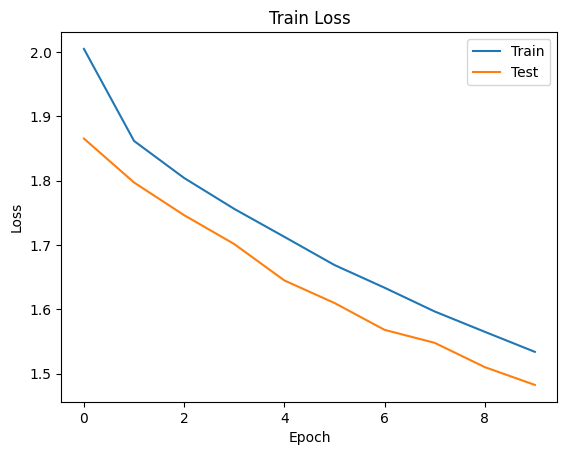

In [16]:
plt.figure()

plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_log['train_loss'], label='Train')
plt.plot(train_log['test_loss'], label='Test')
plt.legend()

plt.show()

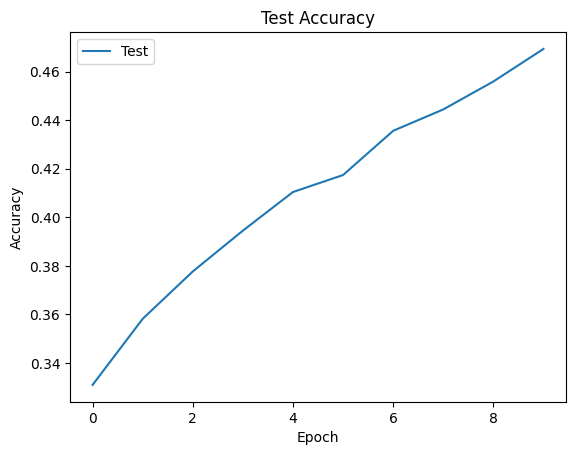

In [17]:
plt.figure()

plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_log['acc'], label='Test')
plt.legend()

plt.show()